## Nanophotonic natural language processing

In [31]:
width, depth = 4, 2  # width and depth of the piece of chip for one word

n_photons = 2
input_modes = output_modes = [0, 1, 1, 0]

bias, weight = -0.7, 5  # bias and weight for the classical post-processing

n_iter, alpha, gamma = 20, 0.602, 0.101  # optimization, hyper-parameters

SEED = 420

In [ ]:
E = [x if not i else x + str(i + 1) 
     for i in range(1) for x in ["Alice", "Bob", "Claire", "Dave", "Eve", "Fred"]]
R = ["loves", "kills", "hates"]

print("Nouns: {}".format(', '.join(E)))
print("Verbs: {}".format(', '.join(R)))

In [ ]:
from discopy import Ty, Word, drawing

n = Ty('n')

class SimpleWord(Word):
    """ Word boxes with `dom == cod == n`. """
    def __init__(self, name, dom=n, cod=n, data=None, _dagger=False):
        super().__init__(name, dom=dom, cod=cod, data=data, _dagger=_dagger)

corpus = {
    ' '.join([x, r, y]):
    SimpleWord(x) >> SimpleWord(r) >> SimpleWord(y).dagger()
    for x in E for r in R for y in E}

print("{} subject-verb-object sentences:".format(len(corpus)))
start = drawing.Equation(*list(corpus.values())[:3], symbol=',')
end = drawing.Equation(*list(corpus.values())[-3:], symbol=',')
drawing.equation(start, end, symbol='...', asymmetry=5e-2, figsize=(10, 2), draw_type_labels=False)

In [ ]:
import numpy as np; np.random.seed(SEED)

from discopy.quantum.optics import Id, MZI

# params : set of MZI phase 
# axis: index of E+R, depth, width, [external,internal]

# generte ansatz for given parameters
def ansatz(params):
    depth, half_width, _ = params.shape
    chip = Id(2 * half_width)
    for i in range(depth):
        chip >>= Id().tensor(*[
                MZI(*params[i, j]) for j in range(half_width)])\
            if not i % 2 else Id(1).tensor(*[
                MZI(*params[i, j]) for j in range(half_width - 1)]) @ Id(1)
    return chip

In [ ]:
n_params

Ansatz for 'Bob' (6 parameters):


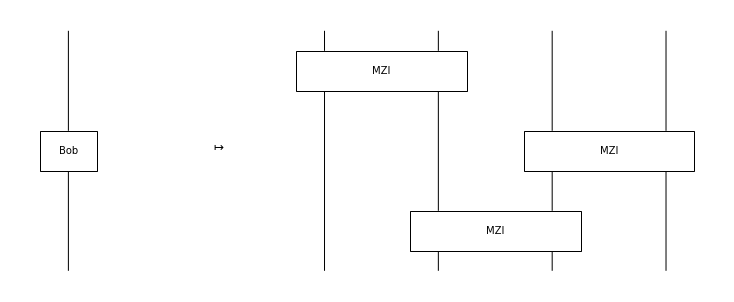

Total: 9 * 6 = 54 parameters.
[0.15192438 0.5807287  0.18929702 ... 0.41410442 0.04911702 0.99226202]


In [12]:
n_params = 2 * (depth * width // 2 - depth // 2)

random_params = lambda: np.random.uniform(size=(len(E + R), depth, width // 2, 2))

params0 = random_params()

print("Ansatz for 'Bob' ({} parameters):".format(n_params))

drawing.equation(
    SimpleWord('Bob'), ansatz(params0[1]),
    draw_type_labels=False, symbol='$\\mapsto$', figsize=(10, 4))

print("Total: {} * {} = {} parameters.".format(len(E + R), n_params, len(E + R) * n_params))
print(params0.flatten())

In [28]:
corpus["Alice loves Bob"]

Diagram(dom=Ty('n'), cod=Ty('n'), boxes=[Word('Alice', Ty('n'), dom=Ty('n')), Word('loves', Ty('n'), dom=Ty('n')), Word('Bob', Ty('n'), dom=Ty('n'))], offsets=[0, 0, 0])

Ansatz for 'Alice loves Bob':


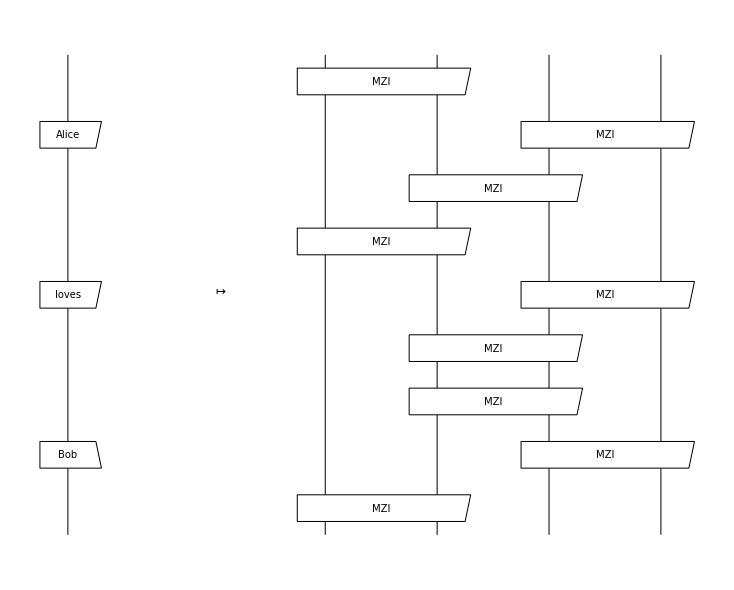

In [29]:
from discopy.quantum.optics import Functor

F = lambda params: Functor(
    ob={n: Ty(1) ** width},
    ar={SimpleWord(w): ansatz(params[i]) for i, w in enumerate(E + R)})

F0 = F(params0)

print("Ansatz for 'Alice loves Bob':")
drawing.equation(
    corpus["Alice loves Bob"], F0(corpus["Alice loves Bob"]),
    symbol='$\\mapsto$', figsize=(10, 8), draw_type_labels=False, asymmetry=5e-2)

In [30]:
probability = lambda amplitude: np.absolute(amplitude) ** 2

activation = lambda x: 1 / (1 + np.exp(-x))
post_processing = lambda x: activation(x * weight + bias)

# evaluate the possibiity of sentence, with the group of parameters
def evaluate(params, sentence):
    params = params.reshape(params0.shape)
    return post_processing(probability(
        F(params)(corpus[sentence]).amp(
            n_photons, input_modes, output_modes)))

%time scores = {sentence: evaluate(params0, sentence) for sentence in corpus}

print("Does Alice love Bob? {} ({:.2F})".format(
    "Yes" if scores["Alice loves Bob"] > .5 else "No", scores["Alice loves Bob"]))

Wall time: 1.39 s
Does Alice love Bob? No (0.43)


Min: 0.33 (Bob hates Alice)
Max: 0.97 (Fred hates Fred)
Mean: 0.50
Standard deviation: 0.16

40 true sentences (score > .5)


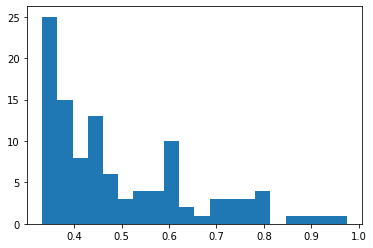

In [32]:
from matplotlib import pyplot as plt

X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dataset = {sentence: int(score > .5) for sentence, score in scores.items()}

train, test = train_test_split(list(corpus), test_size=1 / 3, random_state=42)

print("Training set:\n{}\n{}".format('\n'.join(train[:3]), '...\n' if len(train) > 3 else ''))
print("Testing set:\n{}\n{}".format('\n'.join(test[:3]), '...\n' if len(test) > 3 else ''))

In [ ]:
def loss(corpus, params):
    return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate(params, sentence))
        for sentence in corpus]))

testing_loss = lambda params: loss(test, params)
training_loss = lambda params: loss(train, params)

params = random_params().flatten()

print("Random initialisation, training_loss: {:.3f}, testing loss: {:.3f}".format(
    training_loss(params), testing_loss(params)))
print(params)
print()
print("Does Alice love Bob?")
print("Yes" if evaluate(params, 'Alice loves Bob') > .5 else "No")

In [ ]:
from noisyopt import minimizeSPSA
from time import time 

training_losses, testing_losses = [], []
start = time()
def callback(params):
    training_losses.append(training_loss(params))
    testing_losses.append(testing_loss(params))
    if not len(training_losses) % (n_iter // 10) or len(training_losses) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses), training_losses[-1], testing_losses[-1]))
        print(params)
        print()

result = minimizeSPSA(training_loss, params, paired=False, callback=callback, niter=n_iter, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

In [ ]:
plt.plot(training_losses)

In [ ]:
plt.plot(testing_losses)

In [ ]:
plt.plot(training_losses)
plt.plot(testing_losses)

In [ ]:
from sklearn.metrics import classification_report

y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate(result.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

In [ ]:
y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate(result.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

In [ ]:
y_true = y_train_true + y_test_true
y_pred = y_train_pred + y_test_pred

print(classification_report(y_true, y_pred))